## Set up

In [1]:
import os
base_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir) 

In [10]:
# import requests # request img from web
# import shutil # save img locally
# from pathlib import Path
# from PIL import Image
# import numpy as np
# import math
# import matplotlib.pyplot as plt
import torch
import torchvision
# from torchvision import transforms

In [3]:
import sys
sys.path.append(f'{base_dir}/src/captum')
from captum import optim as optimviz

The tqdm package is required to use captum.optim's n_steps stop criteria with progress bar


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Utilities

In [7]:
def visualize(model: torch.nn.Module, target: torch.nn.Module, neuron: int = -1, 
              neuron_obj: bool = True, lr: float = 0.025) -> None:
    image = optimviz.images.NaturalImage((224, 224)).to(device)
    transforms = [
        # Normalization for torchvision models
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # Random translation, scaling, and rotation to help with visualization quality.
        # Padding is used to avoid transform artifacts and then it's cropped away.
        torch.nn.ReflectionPad2d(16),
        optimviz.transforms.RandomSpatialJitter(16),
        optimviz.transforms.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
        torchvision.transforms.RandomRotation(degrees=(-5,5)),
        optimviz.transforms.RandomSpatialJitter(8),
        optimviz.transforms.CenterCrop((224,224)),
    ]
    transforms = torch.nn.Sequential(*transforms)
    if isinstance(model, optimviz.models.InceptionV1):
        # For the GoogLeNet model, we don't need the initial normalization
        transforms = transforms[1:]
        print("transforms[1:]") ################## test
    else: ######################################## test
        print("transforms") ###################### test
    if neuron > -1:
        if neuron_obj is True: 
            loss_fn = optimviz.loss.NeuronActivation(target, neuron)
        else:
            loss_fn = optimviz.loss.ChannelActivation(target, neuron)
    else:
        loss_fn = optimviz.loss.DeepDream(target)
    obj = optimviz.InputOptimization(model, loss_fn, image, transforms)
    history = obj.optimize(optimviz.optimization.n_steps(128, show_progress=False), lr=lr)   

    print(f"""There are {len(history)} steps in the history.
    Initial loss is {history[0].item()}.
    Final loss is {history[-1].item()}.""")

    image().show()

## Load models

In [8]:
googlenet_torchhub = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True).to(device)
googlenet_torchhub.eval()

Using cache found in /home/lauraom/.cache/torch/hub/pytorch_vision_v0.10.0


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [11]:
googlenet_torchvision = torchvision.models.googlenet(pretrained=True).to(device)
googlenet_torchvision.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [12]:
googlenet_captum = optimviz.models._image.inception_v1.googlenet(pretrained=True).to(device)
googlenet_captum.eval()

InceptionV1(
  (conv1): Conv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2))
  (conv1_relu): RedirectedReluLayer()
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (local_response_norm1): LocalResponseNorm(11, alpha=0.0011, beta=0.5, k=2.0)
  (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv2_relu): RedirectedReluLayer()
  (conv3): Conv2dSame(64, 192, kernel_size=(3, 3), stride=(1, 1))
  (conv3_relu): RedirectedReluLayer()
  (local_response_norm2): LocalResponseNorm(11, alpha=0.0011, beta=0.5, k=2.0)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (mixed3a): InceptionModule(
    (conv_1x1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv_3x3_reduce): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
    (conv_3x3_reduce_relu): RedirectedReluLayer()
    (conv_3x3): Conv2dSame(96, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv_5x5_reduce): Conv2d(192, 16, kernel_size=(1, 1), str

## Visualisations

In [13]:
neuron = 55
target_torchhub = googlenet_torchhub.inception4e.branch1.conv
target_torchvision = googlenet_torchvision.inception4e.branch1.conv
target_captum = googlenet_captum.mixed4e.conv_1x1

transforms


/home/lauraom/anaconda3/envs/sw-interpretability/lib/python3.8/site-packages/torch/_tensor.py:1106: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525491394/work/c10/core/TensorImpl.h:1758.)
  return super(Tensor, self).refine_names(names)


There are 128 steps in the history.
    Initial loss is 0.05558212101459503.
    Final loss is -5.626778602600098.


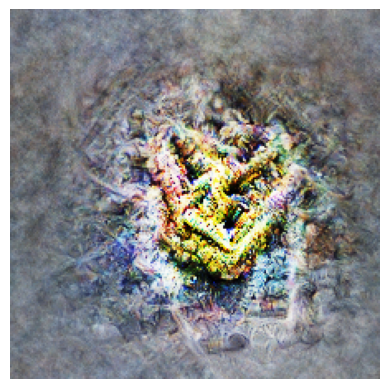

In [14]:
visualize(googlenet_torchhub, target_torchhub, neuron)

transforms
There are 128 steps in the history.
    Initial loss is 0.35273969173431396.
    Final loss is -5.115888595581055.


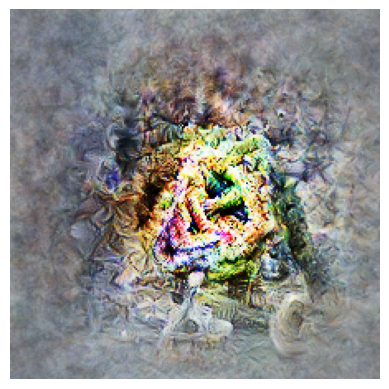

In [15]:
visualize(googlenet_torchvision, target_torchvision, neuron)

transforms[1:]
There are 128 steps in the history.
    Initial loss is 1.7092289924621582.
    Final loss is -1301.3360595703125.


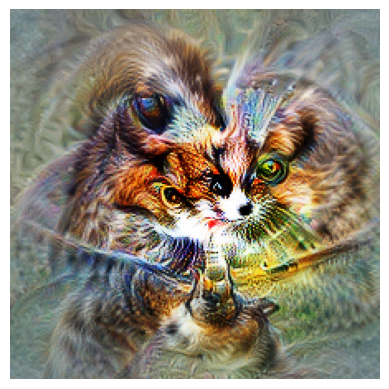

In [16]:
visualize(googlenet_captum, target_captum, neuron) # 55

transforms[1:]
There are 128 steps in the history.
    Initial loss is -4.651504039764404.
    Final loss is -817.6598510742188.


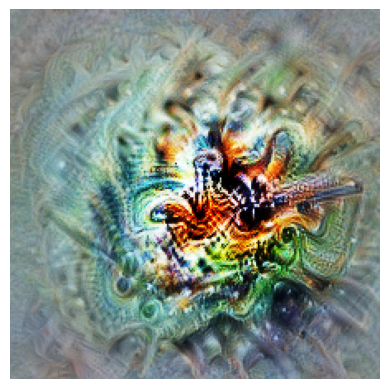

In [17]:
visualize(googlenet_captum, target_captum, 42)

transforms[1:]
There are 128 steps in the history.
    Initial loss is -4.526793956756592.
    Final loss is -937.34765625.


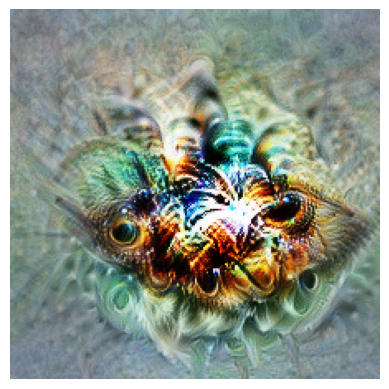

In [18]:
visualize(googlenet_captum, target_captum, 42)